# Tabular Rates and Urca Reactions
pynucastro can generate networks that include tabulated rates such as beta-decays and electron captures. These rates can be very important to applications and pynucastro allows one to seemlessly incorporate them into networks made of Reaclib rates

In [1]:
import pynucastro as pyna

After importing pynucastro we can simply create a list of the rate files we want to include. In this example we represent some simple carbon burning with the addition of the A = 23 Urca reactions (`"na23--ne23-toki", "ne23--na23-toki"`). This is a pair of reactions consisting of:

$$ {}^{23}\mathrm{Ne}  \rightarrow {}^{23}\mathrm{Na} +\mathrm{e}^- + \bar{\nu}_e $$
$$ {}^{23}\mathrm{Na} + \mathrm{e}^- \rightarrow {}^{23}\mathrm{Ne} + \nu_e $$

We can then plot the resulting network to see it's contents more clearly

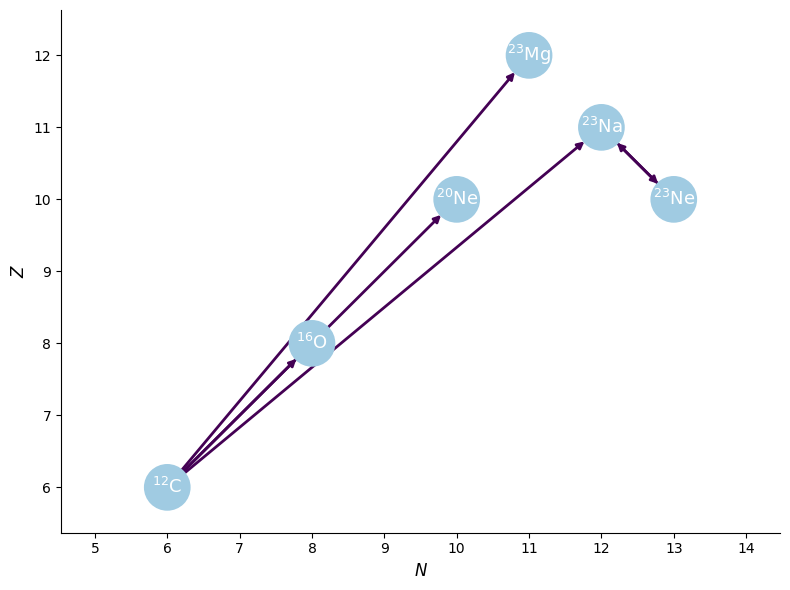

In [2]:
files = ["c12-c12a-ne20-cf88",
         "c12-c12n-mg23-cf88",
         "c12-c12p-na23-cf88",
         "c12-ag-o16-nac2",
         "na23--ne23-toki",
         "ne23--na23-toki",
         "n--p-wc12"]

urca_net = pyna.PythonNetwork(files)

urca_net.plot(outfile="urca_net.pdf")

To see an example of how this network would function in a White Dwarf, we define a composition. We choose a primarily Carbon-Oxygen 40%-60% composition with small amounts of Na23 and Ne23. Then we only need to specify a temperature and density, and pynucastro can calculate the rates and show us what rates are most important during these conditions. 

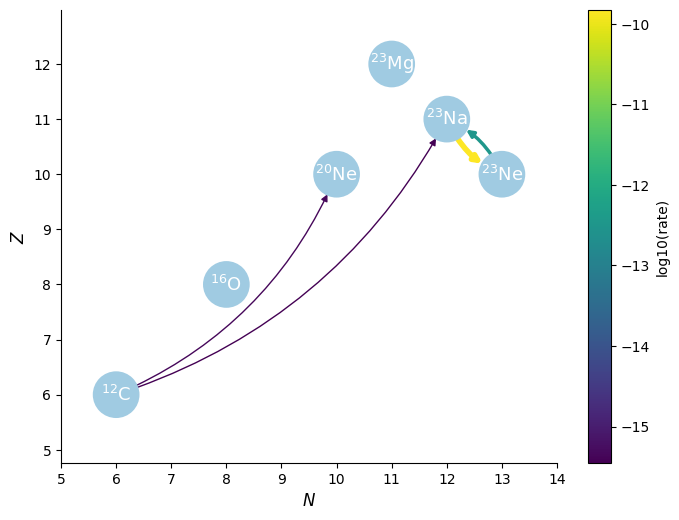

In [3]:
comp = pyna.Composition(urca_net.unique_nuclei)
xvals = [0., 0., 0., 0.3995, 0.5995, 0., 5e-4, 5e-4, 0.]
names = ['n', 'p', 'he4', 'c12', 'o16', 'ne20', 'ne23', 'na23', 'mg23']

for n, X in zip(names, xvals):
    comp.set_nuc(n, X)

comp.normalize()
rho = 2e9 # g/cm**3
temp = 4.5e8 # K
urca_net.plot(comp=comp, rho=rho, T=temp, curved_edges=True, ydot_cutoff_value=1e-20)

Notice in this example, we took a density and temperature such that the Urca reactions would be most important. Though we can also see the rates are unbalanced with a higher rate of electron captures than beta decays.